In [93]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

## Готовим данные

In [2]:
part_1 = pd.read_csv("causal_impact_data_1.csv.gz")

In [3]:
part_2 = pd.read_csv("causal_impact_data_2.csv.gz")

In [4]:
part_3 = pd.read_csv("causal_impact_data_3.csv.gz")

In [5]:
total_df = pd.concat([part_1, part_2, part_3])

In [6]:
total_df["time"] = pd.to_datetime(total_df.time)

In [7]:
#отложим данные для теста

test_data = part_3.loc[(part_3.time >= "2021-12-18") & (part_3.time < "2022-01-17"), :]

In [8]:
del part_1
del part_2
del part_3

Возьмём первые пару месяцев:

In [9]:
print(f"Начало: {total_df.time.min().date()} \nКонец: {(total_df.time.min() + pd.Timedelta(60, unit='d')).date()}")

Начало: 2021-10-19 
Конец: 2021-12-18


In [10]:
total_df = total_df.loc[(total_df.time >= "2021-10-19") & (total_df.time < "2021-12-18"), :]

In [11]:
total_df.shape

(36618223, 5)

In [12]:
total_df.tail()

,user_id,post_id,action,time,is_alert
9704985,57735,4491,view,2021-12-17 23:59:58,False
9704986,8320,4452,view,2021-12-17 23:59:58,False
9704987,156775,4261,view,2021-12-17 23:59:59,False
9704988,135475,4261,view,2021-12-17 23:59:59,False
9704989,51771,4428,view,2021-12-17 23:59:59,False


Теперь сделаем из этого нужные нам характеристики - общее количество событий и DAU в качестве ковариата:

In [13]:
act_df = total_df.set_index("time").resample("D").agg({"user_id": "nunique", 
                                              "action":"count"}).rename({"user_id":"DAU", 
                                                                         "action":"activity"}, axis=1).reset_index()

In [14]:
act_df.shape

(60, 3)

In [15]:
act_df.head()

,time,DAU,activity
0,2021-10-19,976,10235
1,2021-10-20,2341,78996
2,2021-10-21,3202,130601
3,2021-10-22,3814,146685
4,2021-10-23,4704,212915


In [16]:
act_df.tail()

,time,DAU,activity
55,2021-12-13,18171,802057
56,2021-12-14,18761,892514
57,2021-12-15,19507,751924
58,2021-12-16,19712,756124
59,2021-12-17,20202,798208


In [17]:
del total_df

К этому было бы ещё хорошо добавить активность в плане сообщений:

In [18]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT 
    toStartOfDay(time) time, 
    COUNT(reciever_id) actions_mes
FROM simulator.message_actions_all
WHERE time >= toDateTime('2021-10-19 00:00:00') AND time < toDateTime('2021-12-18 00:00:00')
GROUP BY time
ORDER BY time
'''

mes_activity = ph.read_clickhouse(query=query, connection=connection)
mes_activity.head()

,time,actions_mes
0,2021-10-19,3226
1,2021-10-20,12895
2,2021-10-21,12897
3,2021-10-22,12897
4,2021-10-23,12898


In [19]:
act_df = act_df.merge(mes_activity)
act_df.head()

,time,DAU,activity,actions_mes
0,2021-10-19,976,10235,3226
1,2021-10-20,2341,78996,12895
2,2021-10-21,3202,130601,12897
3,2021-10-22,3814,146685,12897
4,2021-10-23,4704,212915,12898


In [20]:
del mes_activity

In [21]:
act_df["total_activity"] = act_df["activity"] + act_df["actions_mes"]
act_df.head()

,time,DAU,activity,actions_mes,total_activity
0,2021-10-19,976,10235,3226,13461.0
1,2021-10-20,2341,78996,12895,91891.0
2,2021-10-21,3202,130601,12897,143498.0
3,2021-10-22,3814,146685,12897,159582.0
4,2021-10-23,4704,212915,12898,225813.0


Порисуем это всё для общей оценки:

<AxesSubplot: xlabel='time', ylabel='DAU'>

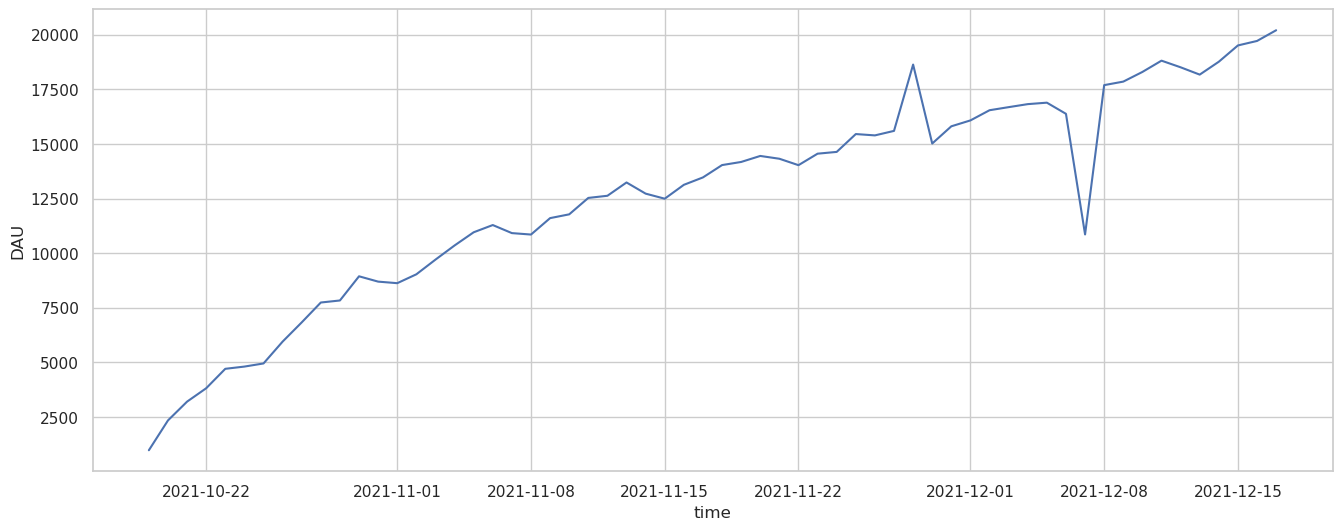

In [22]:
sns.lineplot(data=act_df, x="time", y="DAU")

<AxesSubplot: xlabel='time', ylabel='activity'>

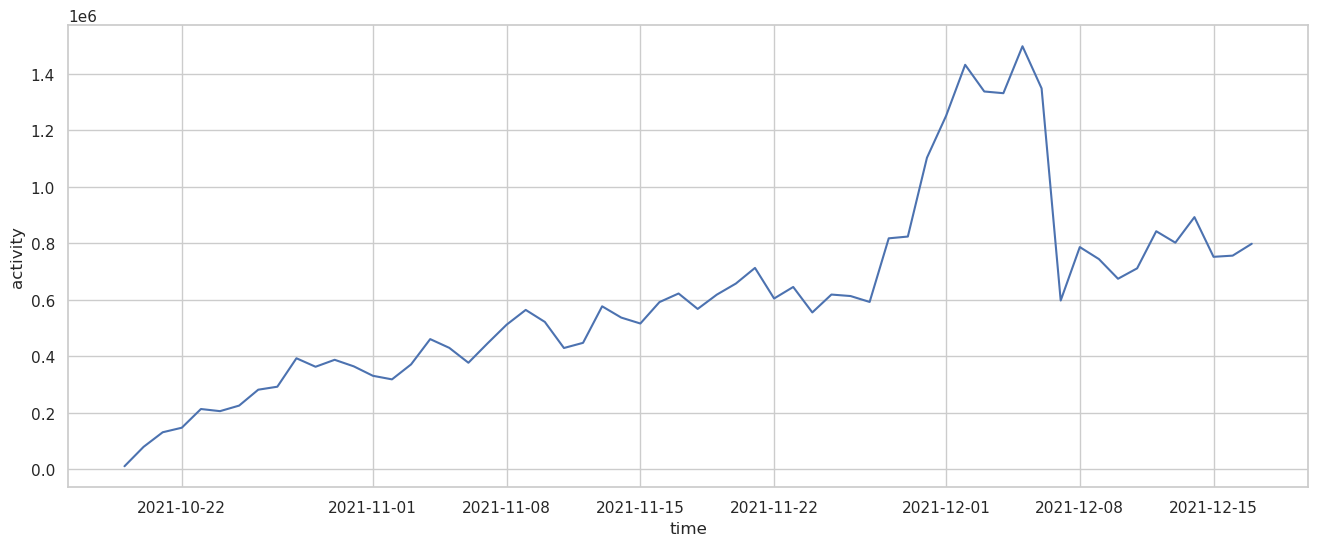

In [23]:
sns.lineplot(data=act_df, x="time", y="activity")

<AxesSubplot: xlabel='time', ylabel='actions_mes'>

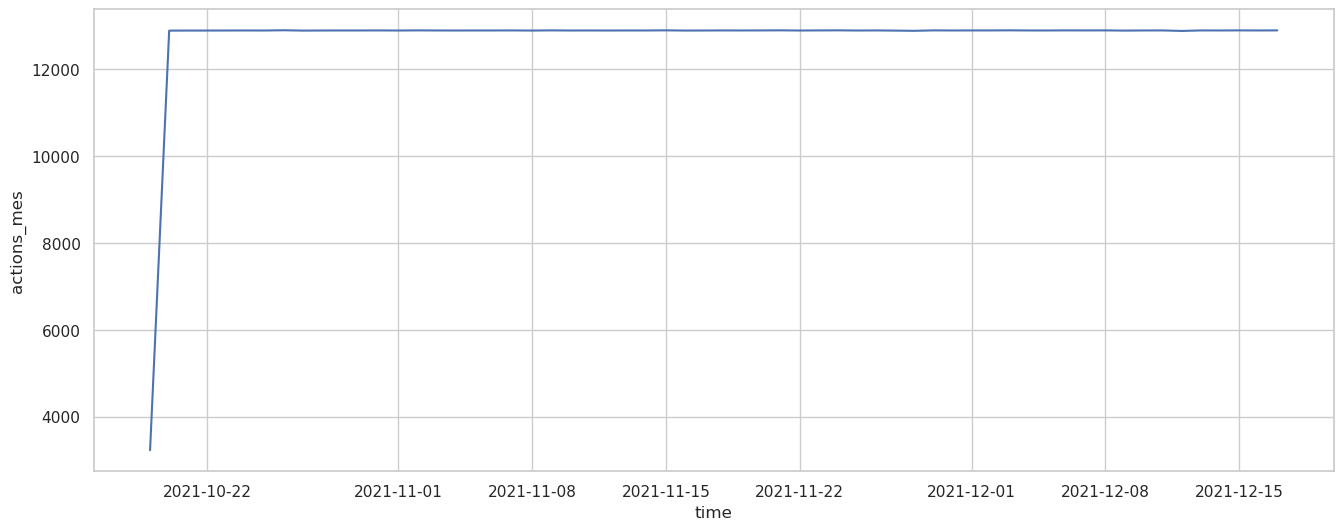

In [24]:
sns.lineplot(data=act_df, x="time", y="actions_mes")

<AxesSubplot: xlabel='time', ylabel='total_activity'>

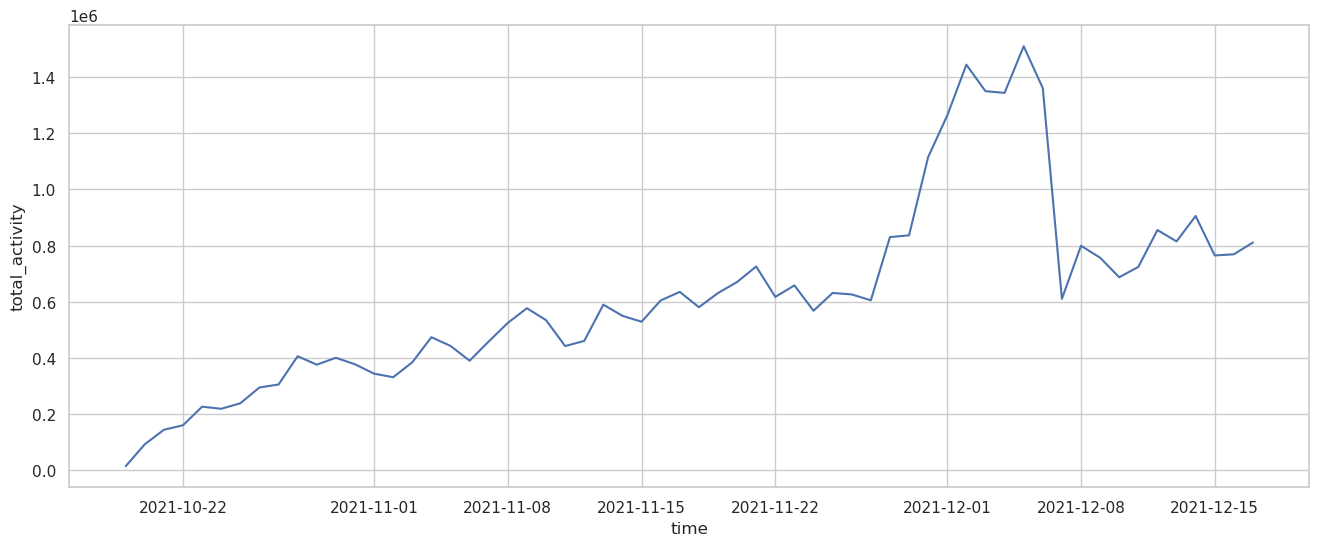

In [25]:
sns.lineplot(data=act_df, x="time", y="total_activity")

Отметим ещё бинарным образом промежуток от 2021-11-28 по 2021-12-06:

In [26]:
act_df["anomaly"] = np.where((act_df.time >= "2021-11-28") & (act_df.time <= "2021-12-06"), 1, 0)
act_df.head()

,time,DAU,activity,actions_mes,total_activity,anomaly
0,2021-10-19,976,10235,3226,13461.0,0
1,2021-10-20,2341,78996,12895,91891.0,0
2,2021-10-21,3202,130601,12897,143498.0,0
3,2021-10-22,3814,146685,12897,159582.0,0
4,2021-10-23,4704,212915,12898,225813.0,0


Для первичной работы лучше стандартизовать наши модели:

In [27]:
act_mean = act_df.total_activity.mean()
act_sd = act_df.total_activity.std()

dau_mean = act_df.DAU.mean()
dau_sd = act_df.DAU.std()

act_df["DAU_stand"] = (act_df.DAU - dau_mean) / dau_sd
act_df["act_stand"] = (act_df.total_activity - act_mean) / act_sd

In [28]:
act_df.head()

,time,DAU,activity,actions_mes,total_activity,anomaly,DAU_stand,act_stand
0,2021-10-19,976,10235,3226,13461.0,0,-2.420571,-1.825568
1,2021-10-20,2341,78996,12895,91891.0,0,-2.137890,-1.590686
2,2021-10-21,3202,130601,12897,143498.0,0,-1.959583,-1.436134
3,2021-10-22,3814,146685,12897,159582.0,0,-1.832843,-1.387965
4,2021-10-23,4704,212915,12898,225813.0,0,-1.648531,-1.189617


## Строим модели

Какие модели у нас будут:

1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [29]:
simple_lin = DLT(response_col="act_stand", 
                 date_col="time", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

simple_loglin = DLT(response_col="act_stand", 
                 date_col="time", 
                 estimator="stan-mcmc", 
                 global_trend_option="loglinear",
                 num_warmup=10000,
                 num_sample=10000)

dau_lin = DLT(response_col="act_stand", 
            date_col="time", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand"], regressor_sign=["+"], 
            num_warmup=10000,
            num_sample=10000)

dau_loglin = DLT(response_col="act_stand", 
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand"], regressor_sign=["+"], 
               num_warmup=10000,
               num_sample=10000)

anom_lin = DLT(response_col="act_stand", 
            date_col="time", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)

anom_loglin = DLT(response_col="act_stand", 
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
               num_warmup=10000,
               num_sample=10000)

In [30]:
#положим в список

model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]

In [31]:
#обучаем

for model in model_list:
    
    model.fit(act_df)

2023-01-28 19:53:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:53:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:53:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:53:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:53:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:53:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Чтобы оценить предсказания, нам надо сотворить future df для наших моделек. Начнём с первых двух:

In [32]:
futur = model_list[0].make_future_df(periods=30)

In [33]:
pred_1 = model_list[0].predict(futur)
pred_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

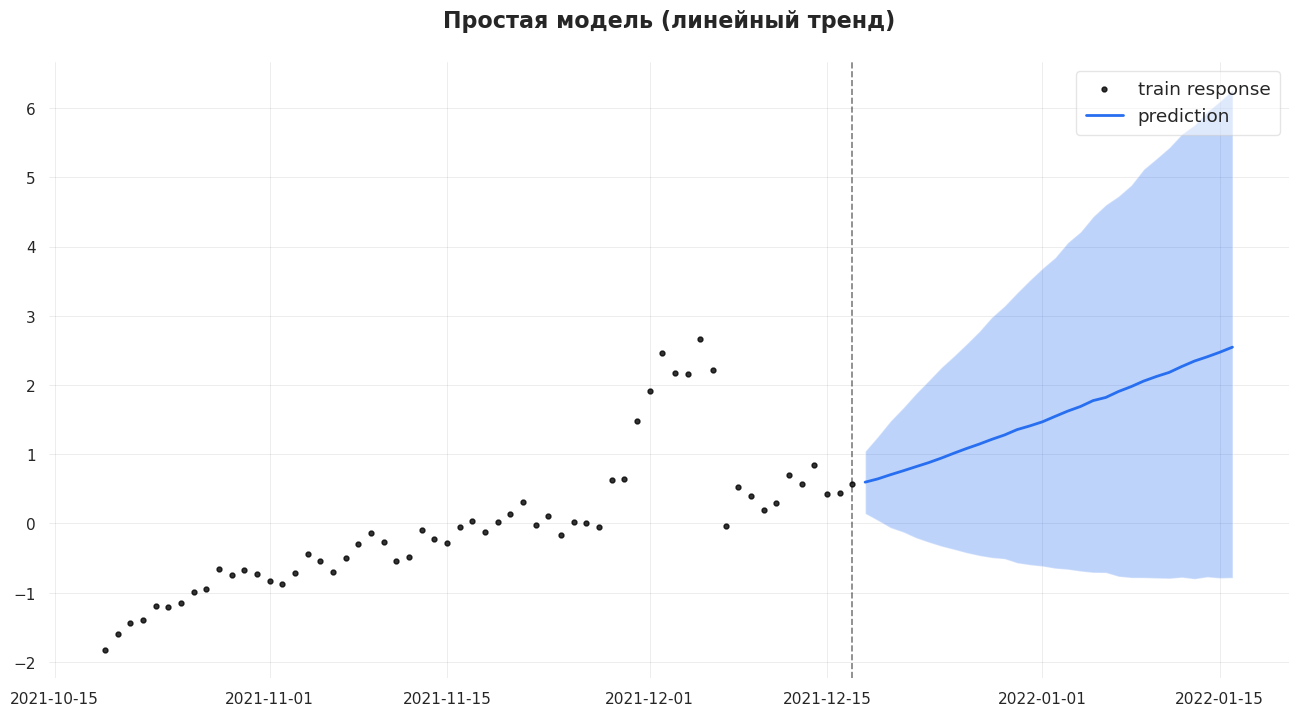

In [34]:
_ = plot_predicted_data(act_df, pred_1, "time", 'act_stand', title='Простая модель (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

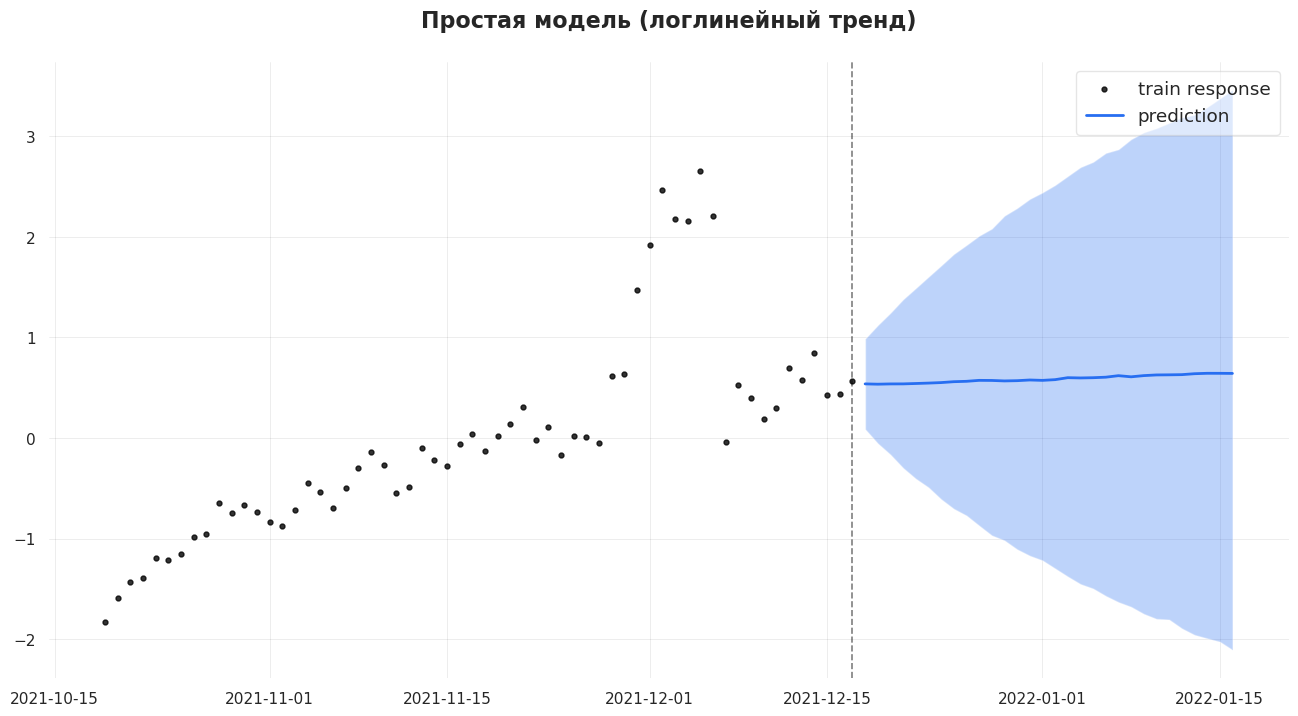

In [35]:
_ = plot_predicted_data(act_df, pred_2, "time", 'act_stand', title='Простая модель (логлинейный тренд)')

Для полагающихся на DAU моделей нам нужно дополнить наш df предсказаниями будущего DAU:

In [36]:
dau_model = DLT(response_col="DAU_stand", 
                 date_col="time", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(act_df)
dau_pred = dau_model.predict(futur)

2023-01-28 19:53:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

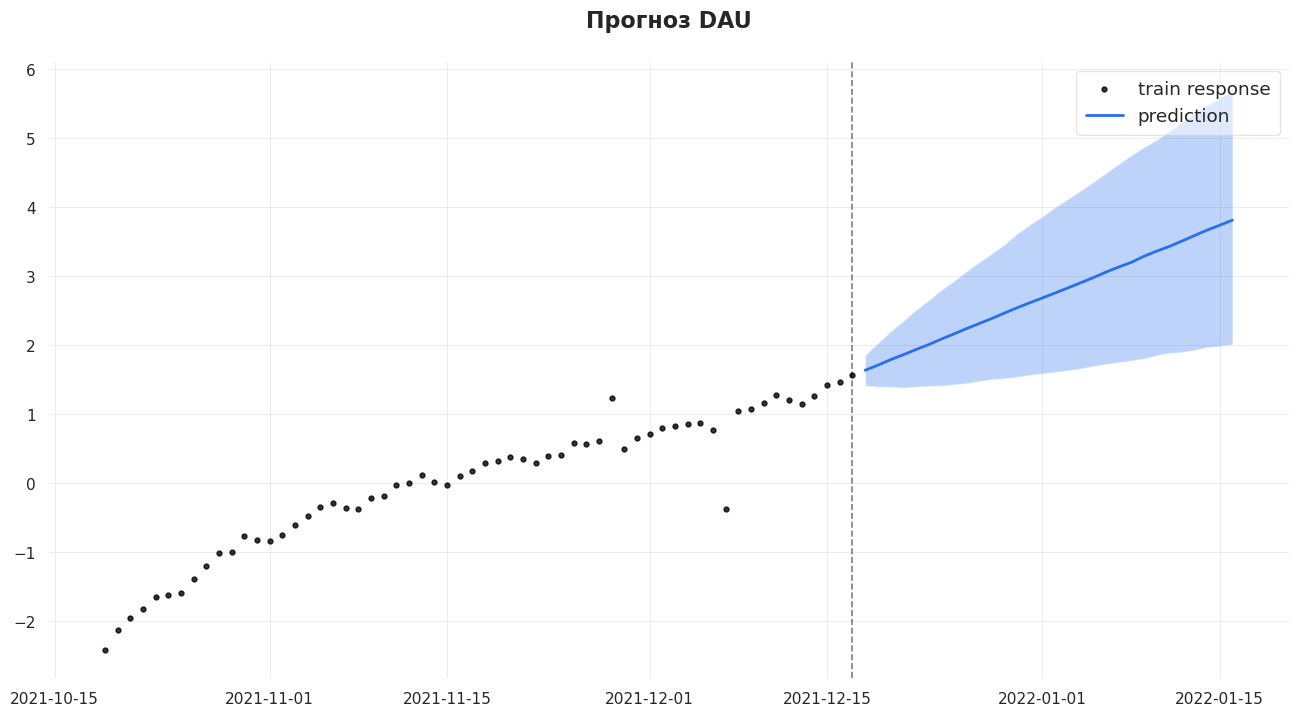

In [37]:
_ = plot_predicted_data(act_df, dau_pred, "time", 'DAU_stand', title='Прогноз DAU')

Добавим линейный прогноз в наш будущий df:

In [38]:
futur["DAU_stand"] = dau_pred.prediction
futur.head()

,time,DAU_stand
0,2021-12-18,1.634326
1,2021-12-19,1.706752
2,2021-12-20,1.786954
3,2021-12-21,1.858271
4,2021-12-22,1.933385


In [39]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,DAU_stand,Positive,0.662144,0.342274,0.971875,1.0,0.0


In [40]:
pred_3 = model_list[2].predict(futur)
pred_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

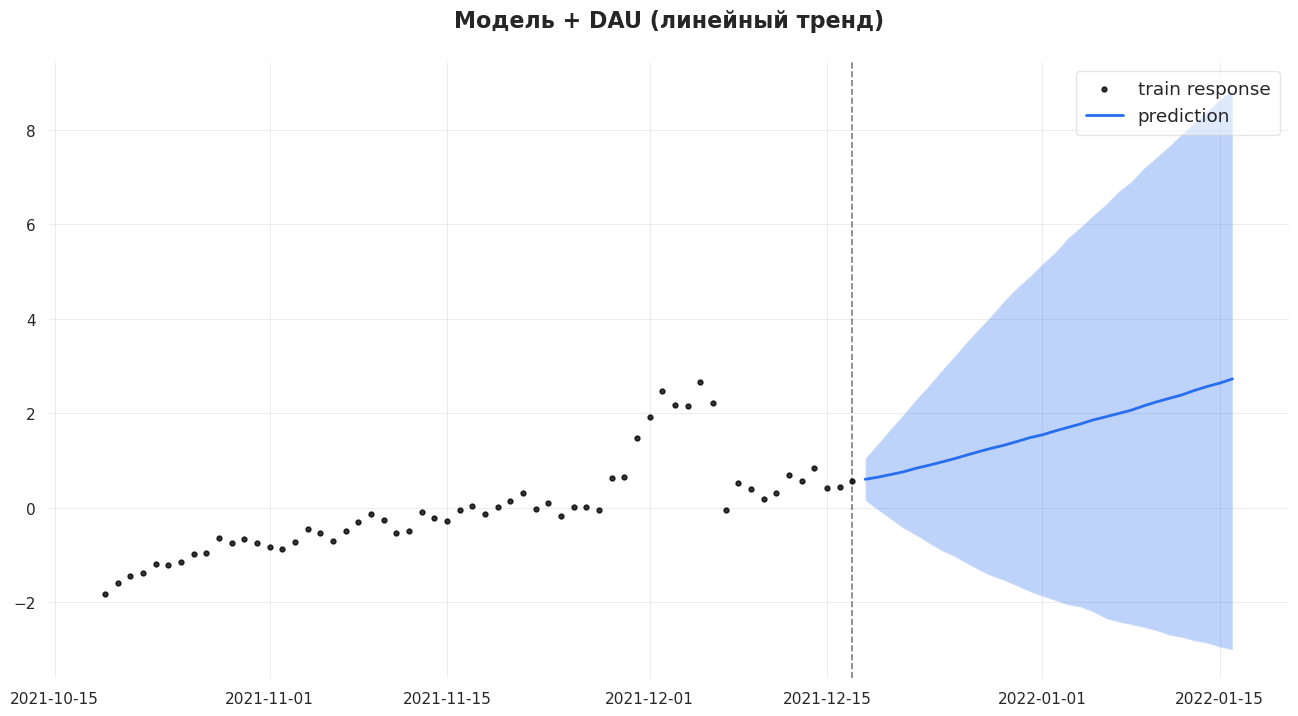

In [41]:
_ = plot_predicted_data(act_df, pred_3, "time", 'act_stand', title='Модель + DAU (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

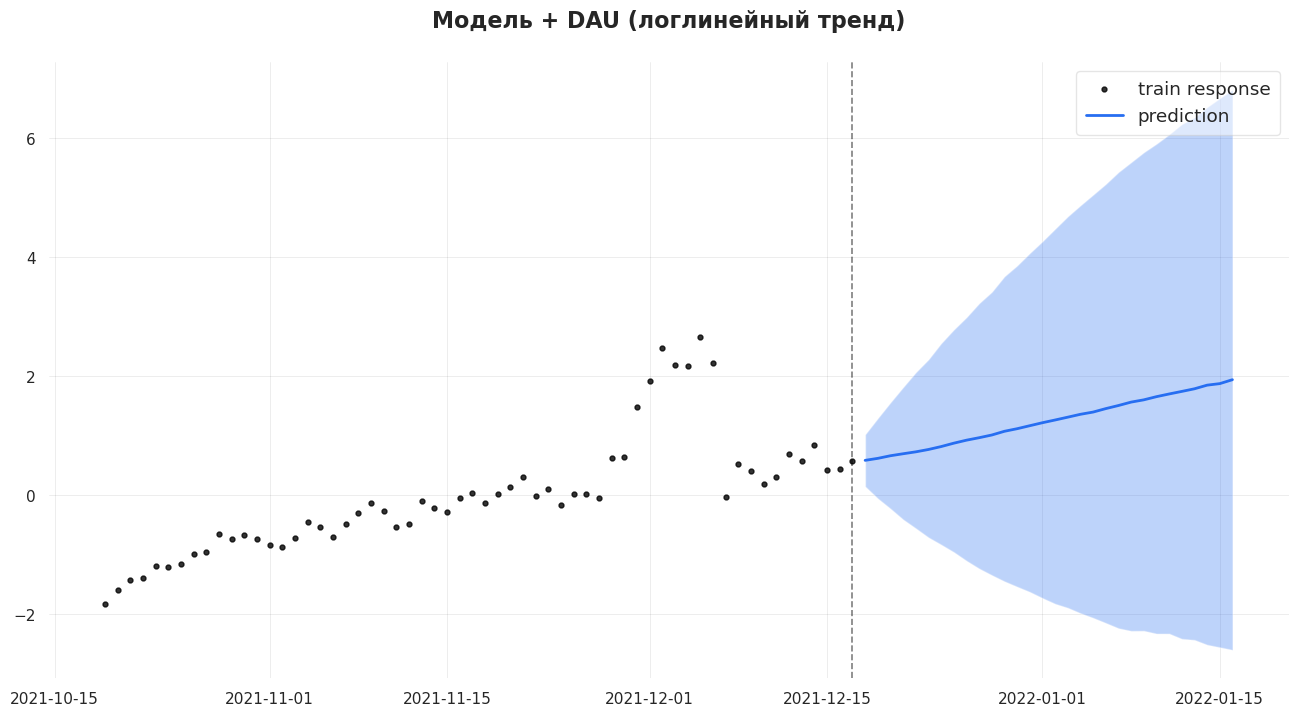

In [42]:
_ = plot_predicted_data(act_df, pred_4, "time", 'act_stand', title='Модель + DAU (логлинейный тренд)')

Наконец, попробуем добавить бинарную переменную:

In [43]:
futur["anomaly"] = 0
futur.head()

,time,DAU_stand,anomaly
0,2021-12-18,1.634326,0
1,2021-12-19,1.706752,0
2,2021-12-20,1.786954,0
3,2021-12-21,1.858271,0
4,2021-12-22,1.933385,0


In [44]:
pred_5 = model_list[4].predict(futur)
pred_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

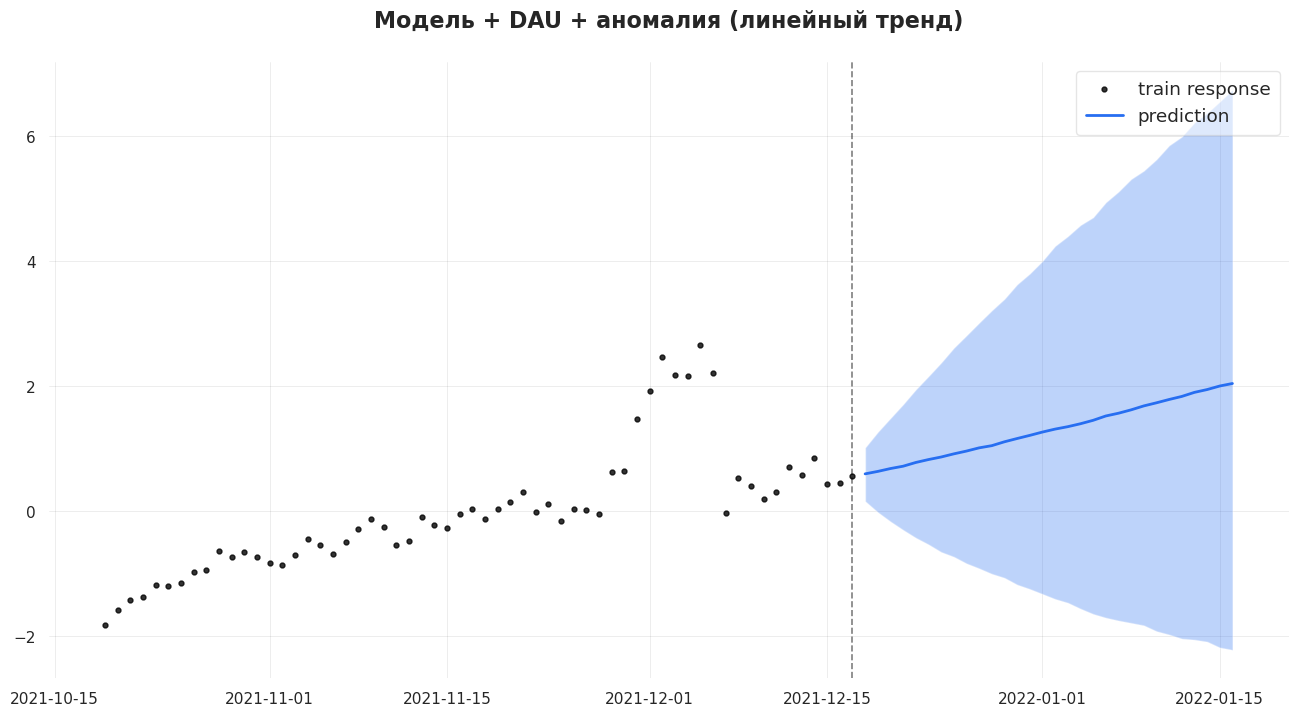

In [45]:
_ = plot_predicted_data(act_df, pred_5, "time", 'act_stand', title='Модель + DAU + аномалия (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

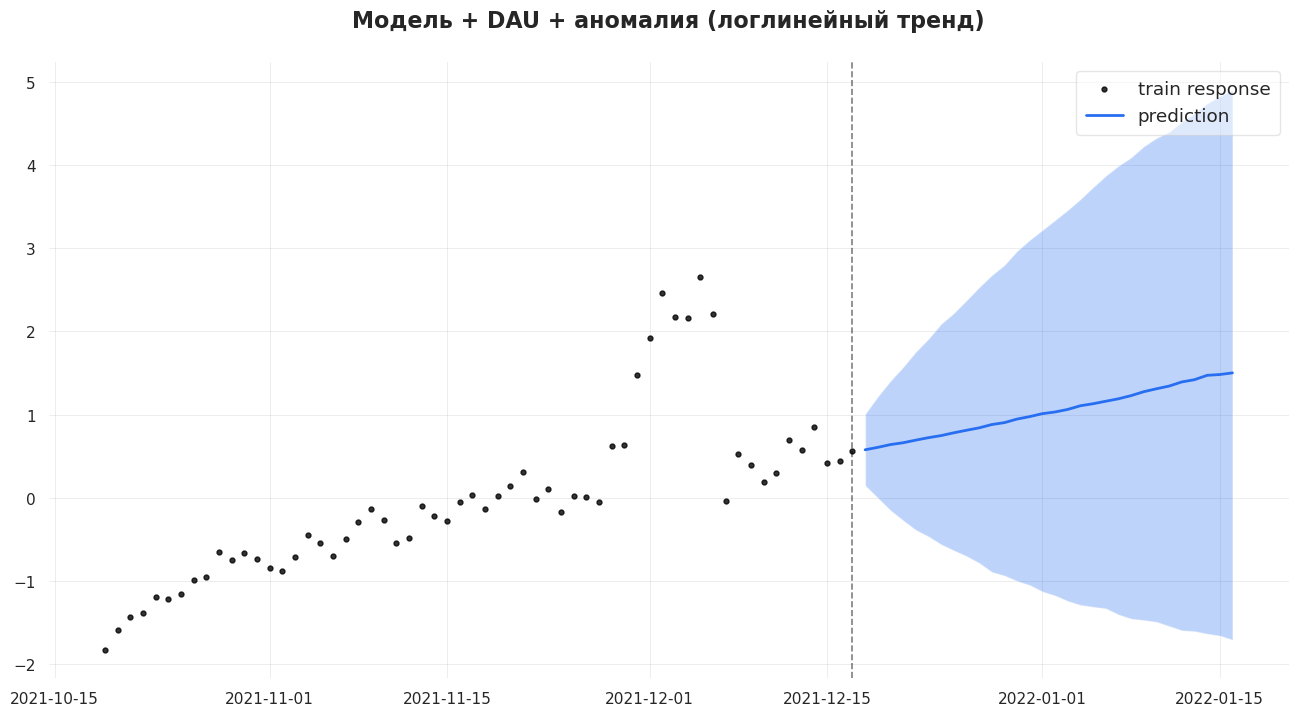

In [46]:
_ = plot_predicted_data(act_df, pred_6, "time", 'act_stand', title='Модель + DAU + аномалия (логлинейный тренд)')

## Оцениваем качество

In [47]:
#сделаем список для бэктестеров
#начнём со скользящего

test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=act_df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2023-01-28 19:54:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:54:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [48]:
test_list_exp = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=act_df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

2023-01-28 19:55:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:55:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:56:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:57:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:58:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Посмотрим, что получилось:

In [49]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [50]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,1.041793,False
1,wmape,1.115417,False
1,mape,5.314927,False
1,mse,1.218763,False
1,mae,0.723859,False


In [51]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 4
Самая лучшая модель по метрике wmape - 6
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 6
Самая лучшая модель по метрике rmsse - 6


In [52]:
exp_df = []

for number, tester in enumerate(test_list_exp):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    exp_df.append(inter_df)
    
exp_df = pd.concat(exp_df)
exp_df = exp_df.set_index("model_number")

In [53]:
for metric in exp_df.metric_name.unique():
    
    winning_model = exp_df.loc[exp_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 6
Самая лучшая модель по метрике wmape - 6
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 6
Самая лучшая модель по метрике rmsse - 6


Итого больше всего склоняется к логлинейной с дополнительной дамми-переменной.

Что по этому поводу скажет WBIC?

In [54]:
for model in model_list:
    
    model.fit_wbic(act_df)

2023-01-28 19:58:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:59:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:59:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:59:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:59:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-01-28 19:59:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.094, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [55]:
for number, model in enumerate(model_list):
    
    print(f"Модель №{number+1}, WBIC = {model.get_wbic()}")

Модель №1, WBIC = 46.253448331209704
Модель №2, WBIC = 45.17875750680432
Модель №3, WBIC = 35.19508345053304
Модель №4, WBIC = 33.90167013623122
Модель №5, WBIC = 30.443067919077865
Модель №6, WBIC = 28.475670789538373


Таким образом, мы скорее склоняемся к модели №6!

## Дополнительный анализ модели №6

Посмотрим пару дополнительных штук относительно последней модели:

In [56]:
comps = model_list[5].predict(futur, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

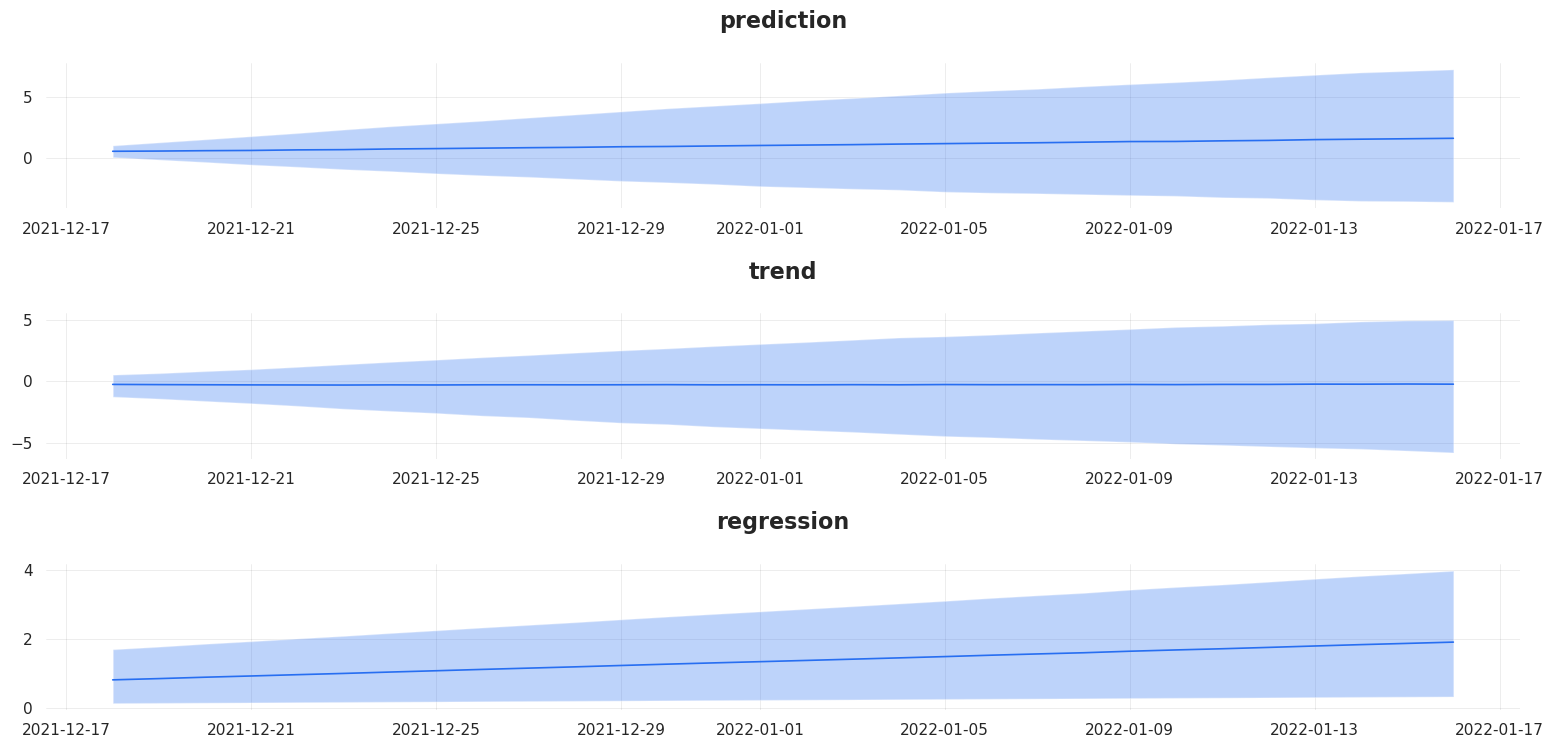

In [57]:
_ = plot_predicted_components(comps, "time", plot_components=['prediction', 'trend', 'regression'])

In [58]:
comps.head()

,time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2021-12-18,0.083645,0.564646,1.041863,-1.254291,-0.254446,0.540765,0.0,0.0,0.0,0.144209,0.817073,1.700628
1,2021-12-19,-0.115447,0.582450,1.293307,-1.414172,-0.271411,0.664361,0.0,0.0,0.0,0.150599,0.853282,1.775992
2,2021-12-20,-0.314086,0.613087,1.542527,-1.607489,-0.283052,0.830577,0.0,0.0,0.0,0.157676,0.893379,1.859448
3,2021-12-21,-0.527554,0.631649,1.798999,-1.793289,-0.294243,0.982942,0.0,0.0,0.0,0.163969,0.929033,1.933658
4,2021-12-22,-0.704425,0.678135,2.056842,-2.002875,-0.300298,1.178231,0.0,0.0,0.0,0.170597,0.966586,2.011819


In [59]:
comps.tail()

,time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
25,2022-01-12,-3.250863,1.450816,6.601845,-5.302702,-0.254016,4.644234,0.0,0.0,0.0,0.309398,1.753023,3.648683
26,2022-01-13,-3.386847,1.515695,6.803649,-5.413587,-0.232501,4.722299,0.0,0.0,0.0,0.316560,1.793601,3.733140
27,2022-01-14,-3.484411,1.551232,6.997391,-5.502525,-0.236474,4.869324,0.0,0.0,0.0,0.323547,1.833189,3.815537
28,2022-01-15,-3.512082,1.585680,7.118242,-5.642856,-0.223394,4.956791,0.0,0.0,0.0,0.329798,1.868607,3.889255
29,2022-01-16,-3.559849,1.622815,7.246146,-5.798793,-0.235827,4.986993,0.0,0.0,0.0,0.336310,1.905502,3.966047


In [60]:
ps = model_list[5].get_posterior_samples(relabel=True, permute=False)
ps.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk', 'DAU_stand', 'anomaly'])

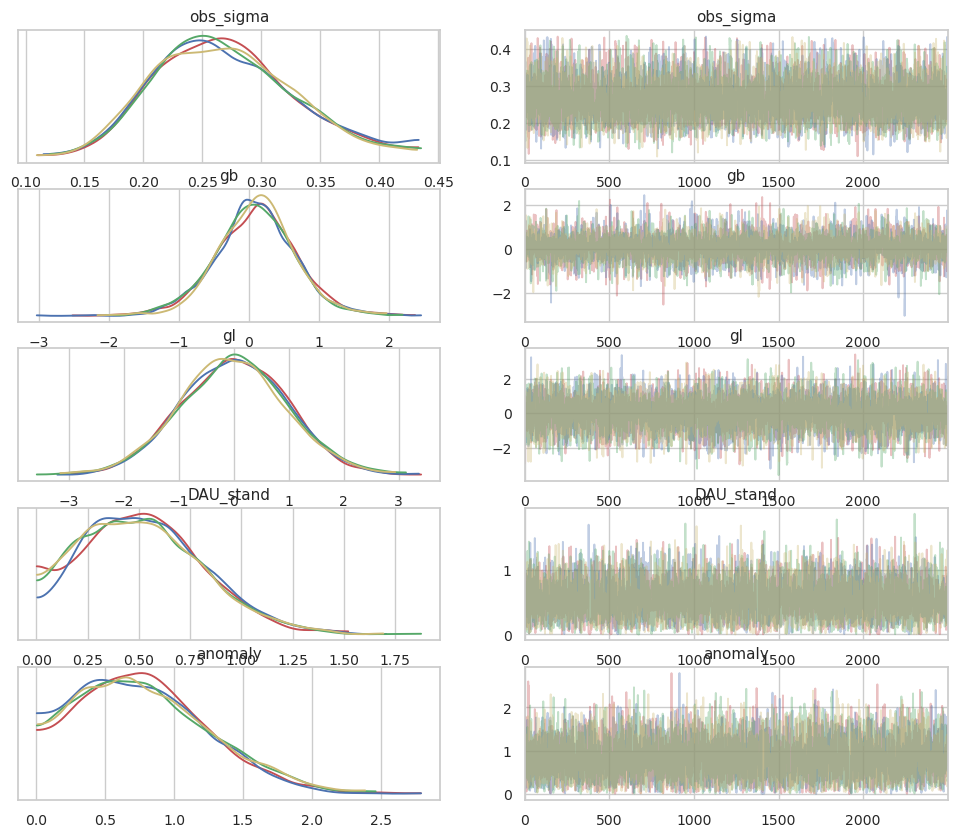

In [61]:
az.plot_trace(
    ps,
    var_names=['obs_sigma', 'gb', 'gl', 'DAU_stand', 'anomaly'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
);

А теперь переведём предсказание в оригинальные единицы измерения:

In [62]:
pred_6[["prediction_5", "prediction", "prediction_95"]] = pred_6[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * act_sd) + act_mean)

In [63]:
pred_6.head()

,time,prediction_5,prediction,prediction_95
0,2021-12-18,672540.687613,815876.467788,9.600879e+05
1,2021-12-19,622888.248152,825621.531850,1.029596e+06
2,2021-12-20,572828.880529,836739.975198,1.092675e+06
3,2021-12-21,532363.884609,844067.556497,1.148310e+06
4,2021-12-22,494203.916376,854575.598790,1.209250e+06


In [64]:
pred_6.tail()

,time,prediction_5,prediction,prediction_95
25,2022-01-12,91567.778992,1.087972e+06,2.131553e+06
26,2022-01-13,88193.038709,1.096974e+06,2.164561e+06
27,2022-01-14,77977.959794,1.114526e+06,2.205538e+06
28,2022-01-15,70361.823844,1.117734e+06,2.233681e+06
29,2022-01-16,53879.563417,1.124357e+06,2.259924e+06


In [65]:
1.124357e+06

1124357.0

## Дополнительно: сравнение с реальными данными

Посмотрим, как оно было на самом деле:

In [66]:
test_data.head()

,user_id,post_id,action,time,is_alert
9704990,129340,4188,like,2021-12-18 00:00:00,False
9704991,28336,4294,like,2021-12-18 00:00:00,False
9704992,64049,4294,view,2021-12-18 00:00:00,False
9704993,165856,4370,view,2021-12-18 00:00:00,False
9704994,108112,4425,view,2021-12-18 00:00:00,False


In [68]:
test_data["time"] = pd.to_datetime(test_data.time)

In [69]:
test_data = test_data.set_index("time").resample("D").agg({"user_id": "nunique", 
                                              "action":"count"}).rename({"user_id":"DAU", 
                                                                         "action":"activity"}, axis=1).reset_index()

In [70]:
test_data.head()

,time,DAU,activity
0,2021-12-18,20510,714428
1,2021-12-19,20301,804231
2,2021-12-20,20012,876735
3,2021-12-21,20391,1061494
4,2021-12-22,20944,973316


In [71]:
test_data.tail()

,time,DAU,activity
25,2022-01-12,25824,1039648
26,2022-01-13,26307,839936
27,2022-01-14,26440,860993
28,2022-01-15,26812,887209
29,2022-01-16,26608,1066175


In [84]:
query = '''
SELECT 
    toStartOfDay(time) time, 
    COUNT(reciever_id) actions_mes
FROM simulator.message_actions_all
WHERE time >= toDateTime('2021-12-18 00:00:00') AND time < toDateTime('2022-01-16 00:00:00')
GROUP BY time
ORDER BY time
'''

mes_activity_test = ph.read_clickhouse(query=query, connection=connection)
mes_activity_test.head()

,time,actions_mes
0,2021-12-18,12899
1,2021-12-19,12900
2,2021-12-20,12900
3,2021-12-21,12900
4,2021-12-22,32259


In [85]:
test_data["activity"] = test_data["activity"] + mes_activity_test["actions_mes"]

In [80]:
(pred_1.prediction * act_sd) + act_mean

0     8.221543e+05
1     8.379890e+05
2     8.580983e+05
3     8.769835e+05
4     8.966622e+05
5     9.160903e+05
6     9.379273e+05
7     9.616658e+05
8     9.844064e+05
9     1.005616e+06
10    1.028687e+06
11    1.049702e+06
12    1.075791e+06
13    1.093534e+06
14    1.113360e+06
15    1.139608e+06
16    1.165108e+06
17    1.187119e+06
18    1.215678e+06
19    1.230833e+06
20    1.259539e+06
21    1.283043e+06
22    1.310044e+06
23    1.332018e+06
24    1.351577e+06
25    1.380143e+06
26    1.406387e+06
27    1.426779e+06
28    1.448912e+06
29    1.473537e+06
Name: prediction, dtype: float64

In [81]:
#добавим прогнозы

test_data["DAU_pred"] = (futur.DAU_stand * dau_sd) + dau_mean
test_data["model1_pred"] = (pred_1.prediction * act_sd) + act_mean
test_data["model2_pred"] = (pred_2.prediction * act_sd) + act_mean
test_data["model3_pred"] = (pred_3.prediction * act_sd) + act_mean
test_data["model4_pred"] = (pred_4.prediction * act_sd) + act_mean
test_data["model5_pred"] = (pred_5.prediction * act_sd) + act_mean
test_data["model6_pred"] = pred_6.prediction

In [86]:
test_data.head()

,time,DAU,activity,DAU_pred,model1_pred,model2_pred,model3_pred,model4_pred,model5_pred,model6_pred
0,2021-12-18,20510,727327.0,20556.142015,822154.310970,802696.145099,823942.899334,817179.545065,820511.364498,815876.467788
1,2021-12-19,20301,817131.0,20905.870633,837989.045034,801708.090678,838587.936063,828392.069265,833593.231616,825621.531850
2,2021-12-20,20012,889635.0,21293.147962,858098.277861,802588.160984,857183.189050,843085.705507,848919.579155,836739.975198
3,2021-12-21,20391,1074394.0,21637.521561,876983.492974,802725.887169,876122.720017,854252.498595,861418.757050,844067.556497
4,2021-12-22,20944,1005575.0,22000.228027,896662.169474,803988.285029,901249.240276,864959.843410,881394.458164,854575.598790


Посмотрим, насколько мы не угадали с DAU:

<AxesSubplot: >

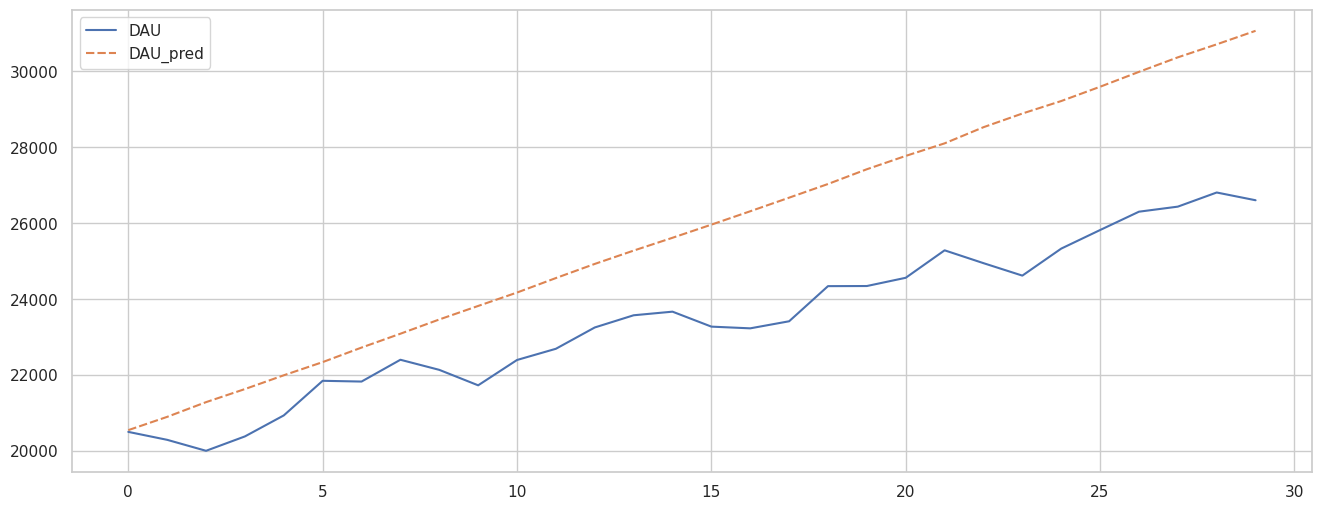

In [89]:
sns.lineplot(test_data.filter(regex=r"time|^DAU"))

И с активностью:

<AxesSubplot: >

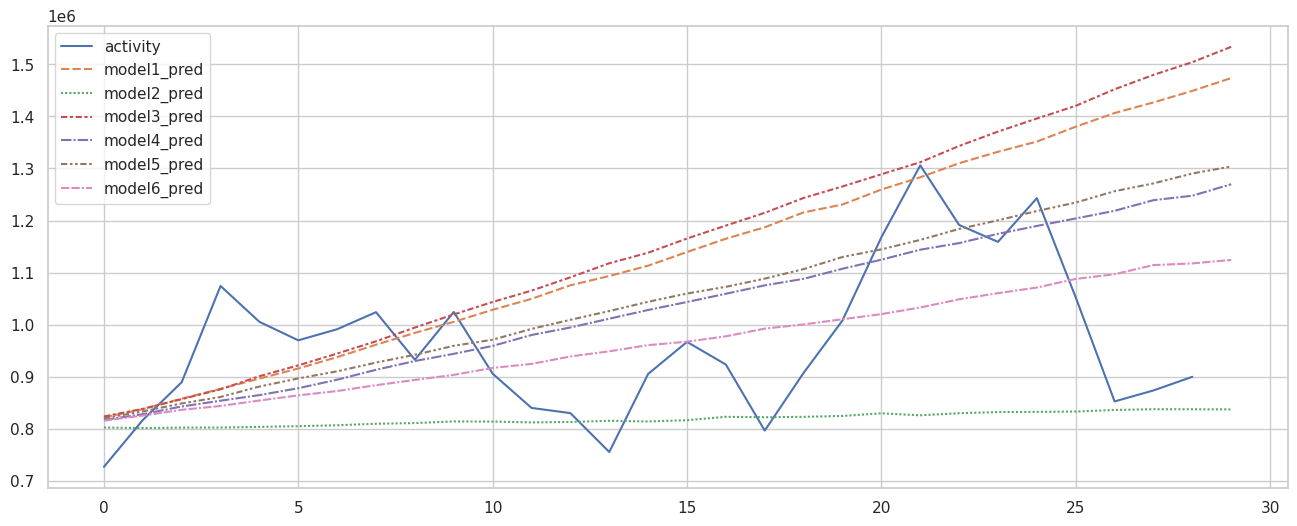

In [95]:
sns.lineplot(test_data.filter(regex=r"time|activity|^model"))

Оценим это чуть более количественно:

In [97]:
test_data.filter(regex=r"^model").columns

Index(['model1_pred', 'model2_pred', 'model3_pred', 'model4_pred',
       'model5_pred', 'model6_pred'],
      dtype='object')

In [98]:
error_df = []

for pred_col in test_data.filter(regex=r"^model").columns:
    
    df = pd.DataFrame({"model":pred_col, 
                       "metric":["mae", "mse", "smape", "wmape"],
                       "value": [mae(test_data.activity, test_data[pred_col]), 
                                 mse(test_data.activity, test_data[pred_col]), 
                                 smape(test_data.activity, test_data[pred_col]), 
                                 wmape(test_data.activity, test_data[pred_col])]})
    error_df.append(df)
    
    

error_df = pd.concat(error_df)


In [99]:
error_df.head()

,model,metric,value
0,model1_pred,mae,1.948066e+05
1,model1_pred,mse,6.277211e+10
2,model1_pred,smape,1.834751e-01
3,model1_pred,wmape,2.014368e-01
0,model2_pred,mae,1.595664e+05


In [100]:
for metric in error_df.metric.unique():
    
    winning_model = error_df.loc[error_df.metric == metric].set_index("model").value.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике mae - model6_pred
Самая лучшая модель по метрике mse - model6_pred
Самая лучшая модель по метрике smape - model6_pred
Самая лучшая модель по метрике wmape - model6_pred
